<a href="https://colab.research.google.com/github/Thiziri-Hafir/Donnees_Massives/blob/main/quarto_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
title: "Projet : Changement de production de café en fonction du climat au Brésil"
format:
  html:
    code-fold: true
jupyter: python3
---

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 36 kB/s 
     |████████████████████████████████| 199 kB 44.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=e7d263b49e9442b1f6c0e33367faaa1a0a07d668c952e77cedc3950a9ce1bf66
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


# Importing the data

In [3]:
import pyspark
import pandas as pd
from pyspark import SparkContext
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt

SparkContext.setSystemProperty('spark.executor.memory', '8g')
SparkContext.setSystemProperty('spark.driver.memory', '45G')

sc = SparkContext.getOrCreate()
spark = SparkSession.builder.appName("Python Spark").getOrCreate()

In [4]:
url = "https://raw.githubusercontent.com/jldbc/coffee-quality-database/master/data/arabica_data_cleaned.csv"
raw_arabica = pd.read_csv(url)

In [5]:
import pyspark.sql.functions as F
from pyspark.sql.types import *

# Auxiliar functions

def count_missings(spark_df,sort=True):
    """
    Counts number of nulls and nans in each column
    """
    df = spark_df.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(c) for (c,c_type) in spark_df.dtypes if c_type not in ('timestamp', 'string', 'date')]).toPandas()

    if len(df) == 0:
        print("There are no any missing values!")
        return None

    if sort:
        return df.rename(index={0: 'count'}).T.sort_values("count",ascending=False)

    return df

def equivalent_type(f):
    """ 
         Function that changes the input Python type to PySpark type
    """
    if f == 'datetime64[ns]': return TimestampType()
    elif f == 'int64': return LongType()
    elif f == 'int32': return IntegerType()
    elif f == 'float64': return DoubleType()
    elif f == 'float32': return FloatType()
    else: return StringType()

def define_structure(string, format_type):
    """ 
         Function that define the structure of the input
    """
    try: typo = equivalent_type(format_type)
    except: typo = StringType()
    return StructField(string, typo)

# Given pandas dataframe, it will return a spark's dataframe.
def pandas_to_spark(pandas_df):
    """ 
         Function that transforms an input pandas dataframe to a spark dataframe
    """
    columns = list(pandas_df.columns)
    types = list(pandas_df.dtypes)
    struct_list = []
    for column, typo in zip(columns, types): 
      struct_list.append(define_structure(column, typo))
    p_schema = StructType(struct_list)
    return spark.createDataFrame(pandas_df, p_schema)

In [6]:
# Creaate a spark dataframe from our initial pandas dataframe 

raw_arabica[['Variety']]= raw_arabica[['Variety']].fillna('unknown')
df_arabica = pandas_to_spark(raw_arabica)  
df_arabica.show(10)

+----------+-------+--------------------+-----------------+--------------------+----------+-----------------+----------+--------------------+-------------+--------------------+--------------------+--------------+----------+--------------------+------------+--------------------+--------------------+-------+-----------------+-----+------+----------+-------+----+-------+----------+---------+---------+-------------+----------------+--------+--------------------+-------+------------+--------------------+--------------------+--------------------+---------------------+---------------------+-------------------+-------------------+--------------------+--------------------+
|Unnamed: 0|Species|               Owner|Country.of.Origin|           Farm.Name|Lot.Number|             Mill|ICO.Number|             Company|     Altitude|              Region|            Producer|Number.of.Bags|Bag.Weight|  In.Country.Partner|Harvest.Year|        Grading.Date|             Owner.1|Variety|Processing.Method|Ar

# Basic structural transformations and harmonization

## Renaming columns and selecting the columns and rows of interest

### In the next cell, we rename the columns to facilitate their use.


In [7]:
tempList = [] #Edit01
for col in df_arabica.columns:
        new_name = col.strip()
        new_name = "".join(new_name.split())
        new_name = new_name.replace('.','_') # EDIT
        tempList.append(new_name) #Edit02
print(tempList) #Just for the sake of it #Edit03

df_arabica = df_arabica.toDF(*tempList) #Edit04

['Unnamed:0', 'Species', 'Owner', 'Country_of_Origin', 'Farm_Name', 'Lot_Number', 'Mill', 'ICO_Number', 'Company', 'Altitude', 'Region', 'Producer', 'Number_of_Bags', 'Bag_Weight', 'In_Country_Partner', 'Harvest_Year', 'Grading_Date', 'Owner_1', 'Variety', 'Processing_Method', 'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Uniformity', 'Clean_Cup', 'Sweetness', 'Cupper_Points', 'Total_Cup_Points', 'Moisture', 'Category_One_Defects', 'Quakers', 'Color', 'Category_Two_Defects', 'Expiration', 'Certification_Body', 'Certification_Address', 'Certification_Contact', 'unit_of_measurement', 'altitude_low_meters', 'altitude_high_meters', 'altitude_mean_meters']


In [8]:
count_missings(df_arabica)

,count
altitude_mean_meters,227
altitude_high_meters,227
altitude_low_meters,227
Quakers,1
Number_of_Bags,0
Category_Two_Defects,0
Category_One_Defects,0
Moisture,0
Total_Cup_Points,0
Cupper_Points,0


#### We decided to focus on Brazil as it is one of the biggest coffee producer and presents interesting geoclimatic features and diversity

In [9]:
df_arabica = df_arabica.filter(df_arabica["Country_of_Origin"]=='Brazil')\
          .distinct()\
          .select(["Farm_name","Altitude","Variety","Aroma","Flavor","Aftertaste",\
                   "Acidity","Body","Balance","Uniformity","Clean_Cup","Sweetness","Total_Cup_Points","altitude_mean_meters"])
df_arabica.show(100, 100)

+-----------------------------------+--------------+--------------+-----+------+----------+-------+----+-------+----------+---------+---------+----------------+--------------------+
|                          Farm_name|      Altitude|       Variety|Aroma|Flavor|Aftertaste|Acidity|Body|Balance|Uniformity|Clean_Cup|Sweetness|Total_Cup_Points|altitude_mean_meters|
+-----------------------------------+--------------+--------------+-----+------+----------+-------+----+-------+----------+---------+---------+----------------+--------------------+
|                                NaN|           NaN|       unknown| 8.58|  8.42|      8.42|    8.5|8.25|   8.33|      10.0|     10.0|     10.0|           88.83|                 NaN|
|                 fazenda capoeirnha|           890|       Bourbon| 7.67|  7.58|       7.5|   7.58|7.58|    7.5|      10.0|     10.0|     10.0|           82.92|               890.0|
|                        capoeirinha|           905|Yellow Bourbon| 7.58|  7.58|      7.58

In [10]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import col

df_arabica = df_arabica.withColumn('Farm_name', regexp_replace(col('Farm_name'), "/", "_"))

In [11]:
# We drop all rows with where altitude_mean_meters==NaN
df_arabica = df_arabica.na.drop(subset=["altitude_mean_meters"]) 

In [12]:
df_arabica.show(10,10)

+----------+--------+----------+-----+------+----------+-------+----+-------+----------+---------+---------+----------------+--------------------+
| Farm_name|Altitude|   Variety|Aroma|Flavor|Aftertaste|Acidity|Body|Balance|Uniformity|Clean_Cup|Sweetness|Total_Cup_Points|altitude_mean_meters|
+----------+--------+----------+-----+------+----------+-------+----+-------+----------+---------+---------+----------------+--------------------+
|fazenda...|     890|   Bourbon| 7.67|  7.58|       7.5|   7.58|7.58|    7.5|      10.0|     10.0|     10.0|           82.92|               890.0|
|capoeir...|     905|Yellow ...| 7.58|  7.58|      7.58|    7.5|7.67|   7.58|      10.0|     10.0|     10.0|           83.08|               905.0|
|olhos d...|    900m|   unknown| 7.58|  7.75|      7.67|    7.5|7.67|   7.58|      10.0|     10.0|     10.0|           83.17|               900.0|
|capoeir...|     905|Yellow ...|  7.5|   7.5|      7.58|    7.5|7.58|   7.58|      10.0|     10.0|     10.0|          

#### At first sight, we can notice that we need to harmonize the Altitude column values and link each Farm_name to its position.


## Harmonizing the altitude column

## Linking Farm_names to actual longitudes and latitudes

 #### We created by hand a dataset with the position of the fields of each Farm_name and performed a simple outer_join

In [13]:
df_farms = spark.createDataFrame(
    [
        ("fazenda rio verde",-21.877600079894428, -45.17833587173798 ), 
        ("fazenda do lobo", -20.05845833645814, -45.551377369807916),
        ("fazenda grota funda",-4.498676298642221, -46.01438009152326),
        ("sitio claro",-12.404400112670487, -57.0307320652044),
        ("santa alina",-21.76121880758086, -46.674253002625804),
        ("fazenda chamusca",-21.4532483711391, -45.22708818550831),
        ("santa maria",-16.609194745742165, -46.98365752985455),
        ("capoeirinha",-18.64698614414741, -45.796849953979795),
        ("fazenda do sertao",-22.09933939187727, -45.18968007378277),
        ("santa fé 2",-17.582654936016926, -47.2198752950817),
        ("café do paraíso",-22.094568087843687, -45.155496432162685),
        ("cachoeira da grama farm",-21.76626556295618, -46.702161544954144),
        ("são francisco da serra",-22.629913000779446, -44.601043902591805),
        ("fazenda jericó",-18.676315608302055, -45.70281563093488),
        ("sertao farm",-22.099418916815903, -45.18965861611114),
        ("campo das flores",-20.312258124962906, -43.28548394936318),
        ("olhos d'agua",-18.63831446703355, -46.952789277527444),
        ("fazenda serra de três barras",-19.560780988980817, -46.579303497451384),
        ("fazenda pantano",-18.631997524421426, -46.82473127385452),
        ("pereira estate coffee",-22.112480964214626, -45.15508902245408),
        ("rio verde",-21.940510105475326, -45.176192869009476),
        ("sitío são geraldo",-22.59528143237296, -46.66759241371165),
        ("fazenda baipendi",-21.45008093579659, -46.8357381855336),
        ("água limpa",-21.44645605895183, -46.82635044153258),
        ("fazenda kaquend",-21.435236392716707, -46.83244978479159),
        ("fazenda santo antonio",-21.40862617568116, -46.80560442679252),
        ("fazenda vista alegre",-21.44237673402853, -46.818513026788274),
        ("fazenda recreio",-21.780100162105256, -46.67880344388111),
        ("fazenda capoeirnha",-21.761009557830032, -46.67507912298348),
        ("pantano",-21.444638601462618, -46.81747769417689),
        ("fazenda são sebastião",-21.444863288363614, -46.827235570452125),
        ("santa bárbara",-18.52732198399872, -47.569893903127564),
        ("santa mariana",-23.19046310851501, -50.55948683365515),
        ("sertao",-22.095760723175886, -45.189755175672296),
        ("são rafael_ ra/ras certified",-22.784292492565246, -47.032534461666536),
        ("sitío santa luzia",-22.366016295045306, -46.47371725096838),
        ("fazenda são josé mirante",-22.785019797545694, -47.03177457322967),
        ("cianorte",-22.774138613223663, -47.02968245276757),
        ("juliana",-21.46270024286904, -46.832515362350975),
        ("sitío corrego da olaria/são caetano",-22.745464486282955, -47.0338567362583),
        ("fazenda serra negra",-21., -46.674253002625804),
        ("fazendas klem ltda",-20.27591897959779, -41.876604035124465),
        ("castelhana farm",-18.922960557030457, -47.45831617257145),
        ("leticia farm",-19.807319369835636, -42.215697182335234),
        ("helena",-22.107657064931225, -48.32067672583973),
        ("caxambu",-21.339808722609096, -45.42201735838091),
    ],
    ["Farm_name", "lat","long"]  # we add column names here
)

In [14]:
# Joining the two dataframes to made one 
df_arabica = df_arabica.join(df_farms, on=['Farm_name'], how='left_outer')

In [15]:
df_arabica.show(10)

+--------------------+------------+--------------+-----+------+----------+-------+----+-------+----------+---------+---------+----------------+--------------------+-------------------+-------------------+
|           Farm_name|    Altitude|       Variety|Aroma|Flavor|Aftertaste|Acidity|Body|Balance|Uniformity|Clean_Cup|Sweetness|Total_Cup_Points|altitude_mean_meters|                lat|               long|
+--------------------+------------+--------------+-----+------+----------+-------+----+-------+----------+---------+---------+----------------+--------------------+-------------------+-------------------+
|   fazenda rio verde|        1260|Yellow Bourbon| 7.58|  7.83|      7.67|   7.25| 8.0|   7.75|      10.0|     10.0|     10.0|            84.0|              1260.0|-21.877600079894428| -45.17833587173798|
| fazenda grota funda|       1200m|       Bourbon|  8.0|  7.92|      7.75|   7.75| 8.0|   7.75|      10.0|     10.0|     10.0|           84.92|              1200.0| -4.498676298642

### We then filter the coffee to keep only those whose origin is known (Farm_name).

In [16]:
df_arabica = df_arabica.filter(df_arabica.Farm_name != "NaN")
df_arabica.show(10)

+--------------------+------------+--------------+-----+------+----------+-------+----+-------+----------+---------+---------+----------------+--------------------+-------------------+-------------------+
|           Farm_name|    Altitude|       Variety|Aroma|Flavor|Aftertaste|Acidity|Body|Balance|Uniformity|Clean_Cup|Sweetness|Total_Cup_Points|altitude_mean_meters|                lat|               long|
+--------------------+------------+--------------+-----+------+----------+-------+----+-------+----------+---------+---------+----------------+--------------------+-------------------+-------------------+
|   fazenda rio verde|        1260|Yellow Bourbon| 7.58|  7.83|      7.67|   7.25| 8.0|   7.75|      10.0|     10.0|     10.0|            84.0|              1260.0|-21.877600079894428| -45.17833587173798|
| fazenda grota funda|       1200m|       Bourbon|  8.0|  7.92|      7.75|   7.75| 8.0|   7.75|      10.0|     10.0|     10.0|           84.92|              1200.0| -4.498676298642

#### We also replace NaN values in the Variety column by "Unknonwn" as the information about the variety is missing.

In [17]:
df_arabica = df_arabica.replace(float('nan'), None)

df_arabica.show(10)

+--------------------+------------+--------------+-----+------+----------+-------+----+-------+----------+---------+---------+----------------+--------------------+-------------------+-------------------+
|           Farm_name|    Altitude|       Variety|Aroma|Flavor|Aftertaste|Acidity|Body|Balance|Uniformity|Clean_Cup|Sweetness|Total_Cup_Points|altitude_mean_meters|                lat|               long|
+--------------------+------------+--------------+-----+------+----------+-------+----+-------+----------+---------+---------+----------------+--------------------+-------------------+-------------------+
|   fazenda rio verde|        1260|Yellow Bourbon| 7.58|  7.83|      7.67|   7.25| 8.0|   7.75|      10.0|     10.0|     10.0|            84.0|              1260.0|-21.877600079894428| -45.17833587173798|
| fazenda grota funda|       1200m|       Bourbon|  8.0|  7.92|      7.75|   7.75| 8.0|   7.75|      10.0|     10.0|     10.0|           84.92|              1200.0| -4.498676298642

# Data Exploration and plotting

#### Now that we cleaned and structured the data, we will explore them to fully understand them and get more details abour their behavour. 

## Location of coffee farms 

#### On the map below, we can see the projection of the farms that produce coffee in Brazil. We can see at first sight that they are mainly in the south east of the country, on the side of the Atlantic Ocean. This gives us a first idea of the meteorological conditions necessary for this production,since the south-east is a region with a subtropical climate. The summer can be very hot, even stifling, and there are many tropical rains, as sudden as they can be violent, especially in Rio and São Paulo. Winter, from June to September, is rather mild, with temperatures between 12 and 25 degrees.

In [18]:
import plotly.express as px
fig = px.scatter_mapbox(df_arabica.toPandas(), lat="lat", lon="long", hover_name="Farm_name", hover_data=["altitude_mean_meters",], color_discrete_sequence=["fuchsia"], zoom=3, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## The correlation between the different taste of coffee variables 

In [19]:
df_arabica.groupBy('Variety')\
          .count().alias("count")\
          .show()

+--------------+-----+
|       Variety|count|
+--------------+-----+
|Yellow Bourbon|   30|
|    Mundo Novo|   16|
|       unknown|    2|
|        Catuai|   16|
|       Bourbon|   39|
| Moka Peaberry|    1|
+--------------+-----+



Using the Seaborn library, we plot the individuals on a dual axis to see if there are overall correlations between the taste variables (aroma, flavor, aftertaste, acidity, sweetness). We can also observe if individuals of the same variety share the same correlation on this axis. Finally we can observe how the varieties are distributed on the correlation axis.

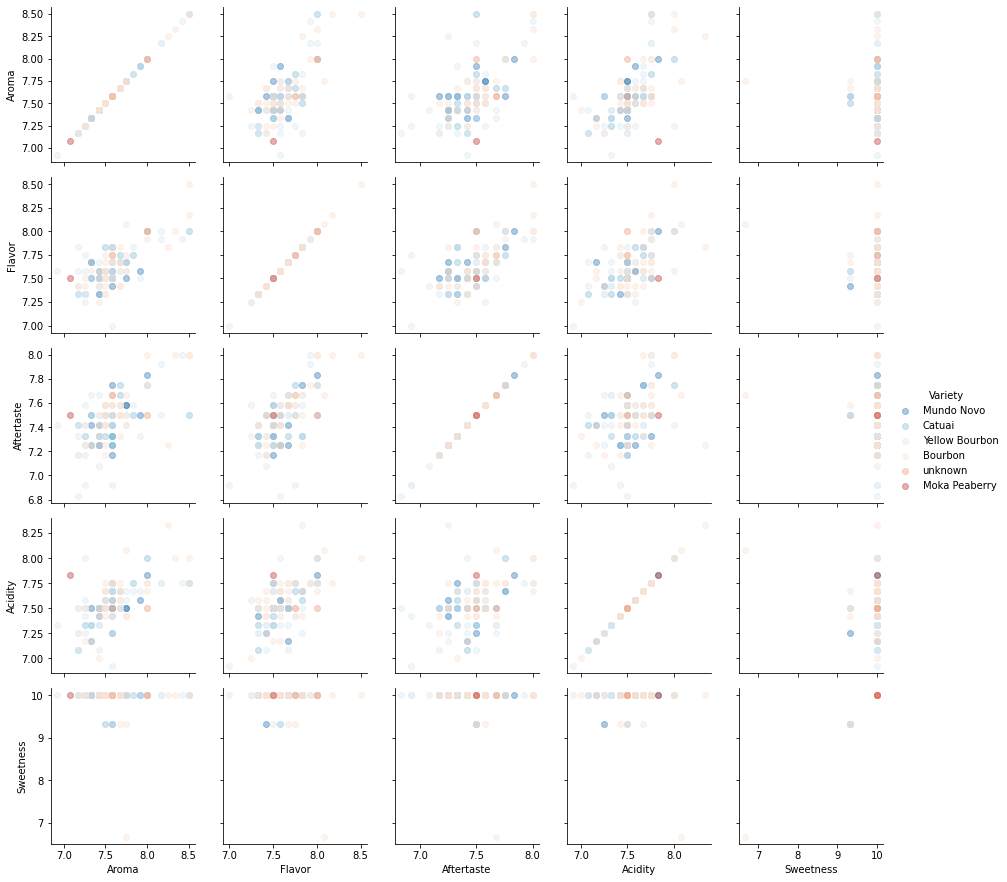

In [20]:
g = sns.PairGrid(df_arabica.toPandas(), vars=['Aroma','Flavor','Aftertaste','Acidity','Sweetness'],
                 hue='Variety', palette='RdBu_r')
g.map(plt.scatter, alpha=0.4)
g.add_legend()

Alternative visualisation

In [21]:
#!pip install seaborn --upgrade 
#if there are errors : upgrade seaborn then restart kernel

LinAlgError: ignored

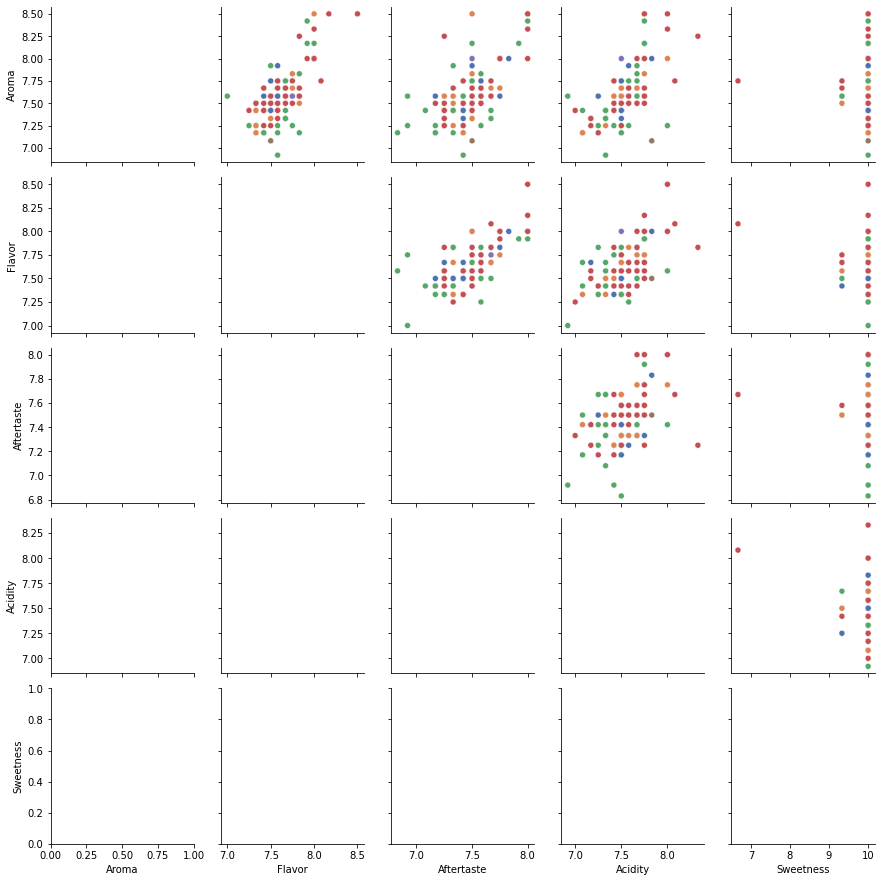

In [22]:
g = sns.PairGrid(df_arabica.toPandas(), vars=['Aroma','Flavor','Aftertaste','Acidity','Sweetness'], hue='Variety', palette = "deep")
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot, warn_singular=False)
g.map_diag(sns.kdeplot, warn_singular=False, lw = 3)
g.add_legend()

We may need more individuals to find a clear pattern.

## Taste profile and scoring relation 

### In the section below, we will see how the different tastes of coffee influence the rating of Total_Cup_Score

#### Creating the features vector which are : Aroma, Flavor, Aftertaste, Acidity, Body, Balance, Uniformity, Clean_Cup, Sweetnes.

In [23]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ["Aroma","Flavor","Aftertaste",\
                   "Acidity","Body", "Balance", "Clean_Cup", "Uniformity","Sweetness"], outputCol = 'features')
vec_df_arabica = vectorAssembler.transform(df_arabica)

#### Train test splitting

In [24]:
train_taste,test_taste  = vec_df_arabica.randomSplit([0.7, 0.3])

##### LR model

In [25]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='Total_Cup_Points', maxIter=10)
lr_model = lr.fit(train_taste)
print("Coefficients: " + str(lr_model.coefficients[:5])+ "\n"+ str(lr_model.coefficients[5:]))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [1.02825663 1.19244051 1.0893845  0.84473943 1.52903298]
[1.32332164 1.07008675 1.22494014 1.01465731]
Intercept: -3.0945756598503786


All taste characteristics are scored out of 10 and the characteristic Total_Cup_Points is their aggregation.

We can therefore assume that all taste characteristics have the same importance.

By running a linear regression model, we can see that all the features have a close importance, but some of them have a slightly greater impact on the model.

We can then make 2 assumptions:

1st assumption: because of the correlation between the characteristics, some of them are considered more important because when their score is high, it increases the score of the others.

2nd assumption: some characteristics have a high variance and the others a low one, those with a high variance will have more impact on the final score.

The slightly more important characteristics seem to be body and balance, but they are not very significant.

In [26]:
# Evaluation on the train data 
print("MSE: ", lr_model.summary.meanSquaredError)
print("MAE: ", lr_model.summary.meanAbsoluteError)
print("R-squared: ", lr_model.summary.r2)

MSE:  0.03674017123281112
MAE:  0.13733059171105555
R-squared:  0.9805621677687725


#### Predicting and evaluating the model

In [27]:
lr_predictions = lr_model.transform(test_taste)
lr_predictions.select("prediction","Total_Cup_Points","features").show(5)

+-----------------+----------------+--------------------+
|       prediction|Total_Cup_Points|            features|
+-----------------+----------------+--------------------+
|80.32533205455645|            80.5|[7.25,7.33,7.17,7...|
|84.36939804484996|           84.17|[7.58,7.83,7.75,7...|
|83.00601214660509|            83.0|[7.5,7.67,7.58,7....|
|82.71264050202623|           82.67|[7.5,7.58,7.25,7....|
|82.34661049306384|           82.33|[7.5,7.5,7.42,7.5...|
+-----------------+----------------+--------------------+
only showing top 5 rows



In [28]:
# Evaluation on test data 
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Total_Cup_Points")

print("MAE on test data = %g" % lr_evaluator.evaluate(lr_predictions, {lr_evaluator.metricName: "mae"}))
print("MSE on test data = %g" % lr_evaluator.evaluate(lr_predictions, {lr_evaluator.metricName: "mse"}))
print("R-squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions, {lr_evaluator.metricName: "r2"}))


MAE on test data = 0.160075
MSE on test data = 0.0442976
R-squared (R2) on test data = 0.980808


#### Th R squared of our model is very high that means that the variation of tastes variables explains very well the note given for a coffee. In the other hand, our model fits quite well the data.

#### In the graph below, we can see that the prediction values curve is almost superimposed on the original values curve

In [29]:
x_ax = range(0,lr_predictions.count())
y_pred = lr_predictions.select("prediction").collect()
y_orig = lr_predictions.select("Total_Cup_Points").collect()

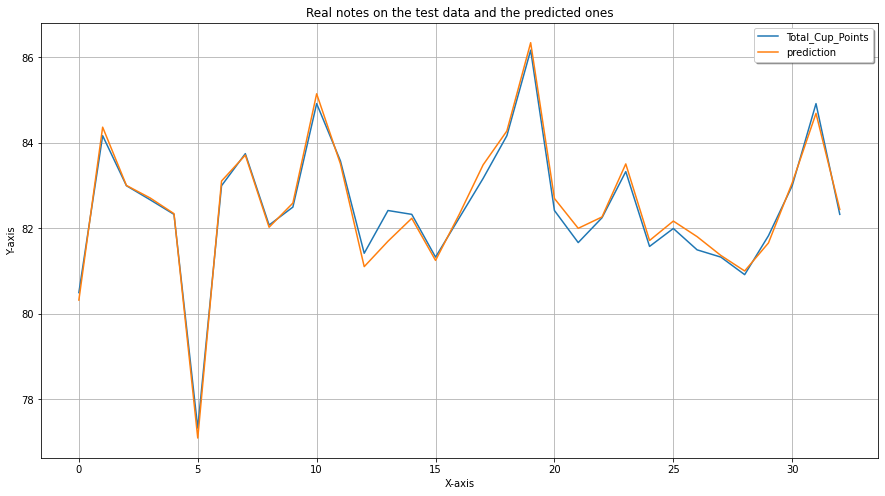

In [30]:
plt.figure(figsize=(15,8))
plt.plot(x_ax, y_orig, label="Total_Cup_Points")
plt.plot(x_ax, y_pred, label="prediction")
plt.title("Real notes on the test data and the predicted ones")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  
 


## Variety and scoring relation

#### For this one we will just use visualizations to see the variation of coffee grade according to the variet.

In [31]:
var = df_arabica.groupBy("Variety").mean("Total_Cup_Points")
var.show()

+--------------+---------------------+
|       Variety|avg(Total_Cup_Points)|
+--------------+---------------------+
|Yellow Bourbon|    82.65233333333335|
|    Mundo Novo|    82.48437499999999|
|       unknown|                83.75|
|        Catuai|             82.60375|
|       Bourbon|    82.90846153846155|
| Moka Peaberry|                82.92|
+--------------+---------------------+



In [32]:
px.bar(var.toPandas(), x='Variety', y='avg(Total_Cup_Points)')

Text(0.5, 1.0, 'Variation of the coffee grade according to the variety')

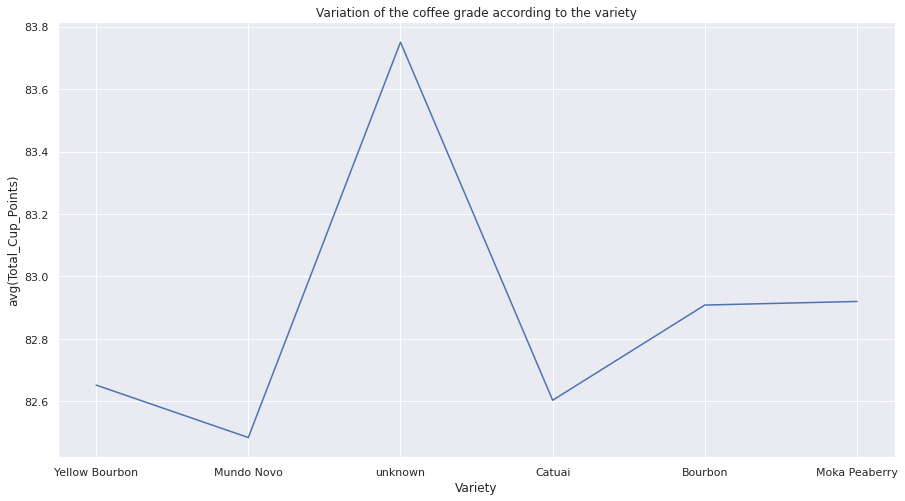

In [33]:
plt.figure(figsize=(15,8))
sns.set_theme(style="darkgrid")
sns.lineplot(x="Variety", y='avg(Total_Cup_Points)', data=var.toPandas()).set_title('Variation of the coffee grade according to the variety')

#### Not a very convincing plot, the Total_Cup_Points are very close (in the 80-90 range) and variety doesn't seem to matter that much

## Farm and scoring relation

In [34]:
farmr = df_arabica.groupBy("Farm_name").mean("Total_Cup_Points")
farmr.show()

+--------------------+---------------------+
|           Farm_name|avg(Total_Cup_Points)|
+--------------------+---------------------+
|fazenda são sebas...|                81.17|
|       santa bárbara|                81.92|
|   fazenda rio verde|              83.1875|
|     fazenda do lobo|                83.17|
| fazenda grota funda|                84.92|
|              sertao|                 81.5|
|         sitio claro|                84.92|
|         santa alina|                84.33|
|   sitío santa luzia|                82.33|
|fazenda são josé ...|                81.08|
|    fazenda chamusca|                82.58|
|         capoeirinha|               82.892|
|   são josé da lagoa|                 82.0|
|   fazenda do sertao|    83.16499999999999|
|fazenda rio brilh...|                81.42|
|          santa fé 2|                82.83|
|sitío corrego da ...|                81.92|
|   fazenda são pedro|                82.33|
|     café do paraíso|    83.08500000000001|
|cachoeira

In [35]:
px.bar(farmr.toPandas().sort_values(by=['avg(Total_Cup_Points)']), x='Farm_name', y='avg(Total_Cup_Points)')

#### Once again the plot is uninteresting, we can try to scale Total_Cup_Points to see more clearly (and with it let's do it on the tastes column since they suffer the same problem)

## Normalizing

In [36]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf

In [37]:
unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())
df_arabica_scaled = df_arabica

for i in ["Aroma","Flavor","Aftertaste",\
                   "Acidity","Body","Balance","Total_Cup_Points"]:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    df_arabica_scaled = pipeline.fit(df_arabica_scaled).transform(df_arabica_scaled).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")

print("After Scaling :")
df_arabica_scaled.show(5)

After Scaling :
+--------------------+--------+--------------+-----+------+----------+-------+----+-------+----------+---------+---------+----------------+--------------------+-------------------+-------------------+------------+-------------+-----------------+--------------+-----------+--------------+-----------------------+
|           Farm_name|Altitude|       Variety|Aroma|Flavor|Aftertaste|Acidity|Body|Balance|Uniformity|Clean_Cup|Sweetness|Total_Cup_Points|altitude_mean_meters|                lat|               long|Aroma_Scaled|Flavor_Scaled|Aftertaste_Scaled|Acidity_Scaled|Body_Scaled|Balance_Scaled|Total_Cup_Points_Scaled|
+--------------------+--------+--------------+-----+------+----------+-------+----+-------+----------+---------+---------+----------------+--------------------+-------------------+-------------------+------------+-------------+-----------------+--------------+-----------+--------------+-----------------------+
|fazenda são sebas...|   1000m|    Mundo Novo| 7

source : https://stackoverflow.com/questions/40337744/scalenormalise-a-column-in-spark-dataframe-pyspark

# Back to Exploration

## Let's try again the previous plots

## Variety

In [38]:
var = df_arabica_scaled.groupBy("Variety").mean("Total_Cup_Points_Scaled")
px.bar(var.toPandas(), x='Variety', y='avg(Total_Cup_Points_Scaled)')

Text(0.5, 1.0, 'Variation of the coffee grade according to the variety')

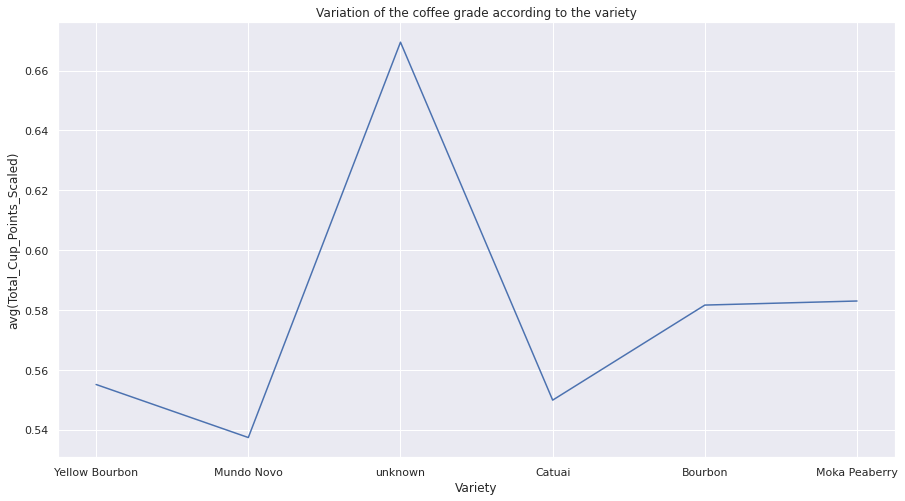

In [39]:
plt.figure(figsize=(15,8))
sns.set_theme(style="darkgrid")
sns.lineplot(x="Variety", y='avg(Total_Cup_Points_Scaled)', data=var.toPandas()).set_title('Variation of the coffee grade according to the variety')

# TOOOOOOOOOOOOOOOOOOOO DOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO

## Farms

In [40]:
farmr = df_arabica_scaled.groupBy("Farm_name").mean("Total_Cup_Points_Scaled")
px.bar(farmr.toPandas().sort_values(by=['avg(Total_Cup_Points_Scaled)']), x='Farm_name', y='avg(Total_Cup_Points_Scaled)')

### Way clearer

#### We can notice that farms are more important offer more distinction than variety, we will see furthermore

## From now on we will use only the scaled version

In [41]:
df_arabica = df_arabica_scaled

cols = ("Aroma","Flavor","Aftertaste",\
                   "Acidity","Body","Balance","Total_Cup_Points")
df_arabica = df_arabica.drop(*cols)
for i in ["Aroma","Flavor","Aftertaste",\
                   "Acidity","Body","Balance","Total_Cup_Points"]:
                   df_arabica = df_arabica.withColumnRenamed(i+"_Scaled", i)

df_arabica.show()
df_arabica.printSchema()

+--------------------+--------------+--------------+----------+---------+---------+--------------------+-------------------+-------------------+-----+------+----------+-------+-----+-------+----------------+
|           Farm_name|      Altitude|       Variety|Uniformity|Clean_Cup|Sweetness|altitude_mean_meters|                lat|               long|Aroma|Flavor|Aftertaste|Acidity| Body|Balance|Total_Cup_Points|
+--------------------+--------------+--------------+----------+---------+---------+--------------------+-------------------+-------------------+-----+------+----------+-------+-----+-------+----------------+
|fazenda são sebas...|         1000m|    Mundo Novo|      10.0|     10.0|     10.0|              1000.0|-21.444863288363614|-46.827235570452125|0.316|  0.22|     0.359|  0.355|0.447|    0.2|             0.4|
|       santa bárbara|          1020|        Catuai|      10.0|     10.0|     10.0|              1020.0| -18.52732198399872|-47.569893903127564|0.316|  0.22|     0.427|

## Farms all of fame and their strengths

### Since farms seem interesting we can plot radar plots of the taste they offer (meaned).
#### We will focus on the most renowed farms

In [42]:
from pyspark.sql.functions import desc
hof = df_arabica.groupBy("Farm_name").mean("Total_Cup_Points").sort(desc("avg(Total_Cup_Points)"))
hof.show(6)

+--------------------+---------------------+
|           Farm_name|avg(Total_Cup_Points)|
+--------------------+---------------------+
|     fazenda kaquend|                0.956|
|     fazenda recreio|                0.852|
|fazenda serra de ...|                0.844|
|   sitío são geraldo|                  0.8|
| fazenda grota funda|                0.791|
|         sitio claro|                0.791|
+--------------------+---------------------+
only showing top 6 rows



We will take the top 3

# FAIIIIIIIIIRE

In [43]:
li = hof.select("Farm_name").take(3)[:3]

In [44]:
li

[Row(Farm_name='fazenda kaquend'),
 Row(Farm_name='fazenda recreio'),
 Row(Farm_name='fazenda serra de três barras')]

In [45]:
li = ["fazenda kaquend","fazenda recreio","sitío são geraldo","sitio claro","fazenda grota funda"]

Meaner par farm

In [46]:
df_hof = df_arabica.filter(df_arabica.Farm_name.isin(li))
df_hof.show()

+-------------------+--------+----------+----------+---------+---------+--------------------+-------------------+------------------+-----+------+----------+-------+-----+-------+----------------+
|          Farm_name|Altitude|   Variety|Uniformity|Clean_Cup|Sweetness|altitude_mean_meters|                lat|              long|Aroma|Flavor|Aftertaste|Acidity| Body|Balance|Total_Cup_Points|
+-------------------+--------+----------+----------+---------+---------+--------------------+-------------------+------------------+-----+------+----------+-------+-----+-------+----------------+
|fazenda grota funda|   1200m|   Bourbon|      10.0|     10.0|     10.0|              1200.0| -4.498676298642221|-46.01438009152326|0.684| 0.613|     0.786|  0.589| 0.78|  0.664|           0.791|
|        sitio claro|  1000 m|    Catuai|      10.0|     10.0|     10.0|              1000.0|-12.404400112670487| -57.0307320652044|0.684| 0.667|     0.786|  0.766|0.447|  0.664|           0.791|
|  sitío são geraldo

In [47]:
import plotly.graph_objects as go
from pyspark.sql.functions import mean

categories = ["Aroma","Flavor","Aftertaste",\
                   "Acidity","Body","Balance"]

df_hof_pd = df_hof.select(["Farm_name","Aroma","Flavor","Aftertaste",\
                   "Acidity","Body","Balance"]).toPandas().set_index('Farm_name')


df_mean_pd = df_arabica.select(mean("Aroma"), mean("Flavor")\
                               , mean("Aftertaste"), mean("Acidity"), mean("Body"), mean("Balance"))\
                               .toPandas()

fig = go.Figure()

for g in df_hof_pd.index:
    fig.add_trace(go.Scatterpolar(
        r = df_hof_pd.loc[g].values,
        theta = categories,
        fill = "toself",
        name = f'{g}'
    ))


fig.add_trace(go.Scatterpolar(
        r = df_mean_pd.values,
        theta = categories,
        fill = "toself",
        name = f'MEAN'
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=False,
      range=[0, 1]
    )),
  showlegend=False
)

fig.show()

## The climat of Brazil over the last 22 years

In [75]:
url = "/content/gdrive/MyDrive/donmass_proj/"
# Brazil's weather stations
stations_brazil = pd.read_csv(url+"stations.csv")

In [88]:
stations_brazil.head()

,region,state,city_station,id_station,lat,lon,lvl,record_first,record_last
0,CO,DF,BRASILIA,A001,"-15,78944444","-47,92583332","1159,54",2000-05-07,2022-08-31
1,NE,BA,SALVADOR,A401,"-13,01666666","-38,51666666","51,41",2000-05-13,2022-08-31
2,N,AM,MANAUS,A101,"-3,10333333","-60,01638888","61,25",2000-05-09,2022-08-31
3,SE,RJ,ECOLOGIA AGRICOLA,A601,"-22,8","-43,68333333",33,2000-05-07,2022-08-31
4,S,RS,PORTO ALEGRE,A801,"-30,05","-51,16666666","46,97",2000-09-22,2022-08-31


In [89]:
stations_brazil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   region        613 non-null    object
 1   state         613 non-null    object
 2   city_station  613 non-null    object
 3   id_station    613 non-null    object
 4   lat           613 non-null    object
 5   lon           613 non-null    object
 6   lvl           613 non-null    object
 7   record_first  613 non-null    object
 8   record_last   613 non-null    object
dtypes: object(9)
memory usage: 43.2+ KB


In [48]:
# Brazil's weather 22 year history
weather_brazil = pd.read_csv(url+"weather_sum_all.csv")

In [49]:
weather_brazil.head()

,ESTACAO,DATA (YYYY-MM-DD),rain_max,rad_max,temp_avg,temp_max,temp_min,hum_max,hum_min,wind_max,wind_avg
0,A001,2000-05-07,0.0,2915.0,25.125000,28.3,20.7,69.0,36.0,6.3,1.766667
1,A001,2000-05-08,0.0,3126.0,22.104167,28.2,16.5,86.0,33.0,7.1,2.066667
2,A001,2000-05-09,0.0,2901.0,22.041667,28.7,16.6,79.0,37.0,7.0,1.150000
3,A001,2000-05-10,0.0,2972.0,22.462500,28.9,17.7,82.0,35.0,6.3,2.008333
4,A001,2000-05-11,0.0,2958.0,21.329167,27.3,16.6,80.0,35.0,7.3,2.670833


In [50]:
weather_brazil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2561825 entries, 0 to 2561824
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ESTACAO            object 
 1   DATA (YYYY-MM-DD)  object 
 2   rain_max           float64
 3   rad_max            float64
 4   temp_avg           float64
 5   temp_max           float64
 6   temp_min           float64
 7   hum_max            float64
 8   hum_min            float64
 9   wind_max           float64
 10  wind_avg           float64
dtypes: float64(9), object(2)
memory usage: 215.0+ MB


In [51]:
weather_brazil = weather_brazil.fillna(method='ffill')

In [65]:
# new datetime column 
weather_brazil['datetime'] = pd.to_datetime(weather_brazil['DATA (YYYY-MM-DD)'], format='%Y-%m-%d %H:%M:%S')

In [68]:
weather_brazil['year'] = weather_brazil['datetime'].dt.year

<Figure size 1080x576 with 0 Axes>

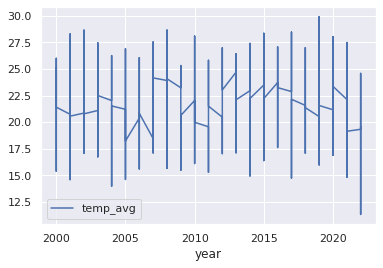

In [95]:
plt.figure(figsize=(15,8))
station_A001 = weather_brazil ['ESTACAO'] == 'A001'
w_station_A001 = weather_brazil[station_A001]
w_station_A001.plot(x='year', y='temp_avg')

##### Convert the Pandas datframe to a spark dataframe

In [53]:
df_weather = pandas_to_spark(weather_brazil)

In [54]:
type(df_weather)

pyspark.sql.dataframe.DataFrame

In [55]:
df_weather.printSchema()

root
 |-- ESTACAO: string (nullable = true)
 |-- DATA (YYYY-MM-DD): string (nullable = true)
 |-- rain_max: double (nullable = true)
 |-- rad_max: double (nullable = true)
 |-- temp_avg: double (nullable = true)
 |-- temp_max: double (nullable = true)
 |-- temp_min: double (nullable = true)
 |-- hum_max: double (nullable = true)
 |-- hum_min: double (nullable = true)
 |-- wind_max: double (nullable = true)
 |-- wind_avg: double (nullable = true)



In [56]:
df_weather.show(10)

+-------+-----------------+--------+-------+------------------+--------+--------+-------+-------+--------+------------------+
|ESTACAO|DATA (YYYY-MM-DD)|rain_max|rad_max|          temp_avg|temp_max|temp_min|hum_max|hum_min|wind_max|          wind_avg|
+-------+-----------------+--------+-------+------------------+--------+--------+-------+-------+--------+------------------+
|   A001|       2000-05-07|     0.0| 2915.0|            25.125|    28.3|    20.7|   69.0|   36.0|     6.3|1.7666666666666666|
|   A001|       2000-05-08|     0.0| 3126.0|22.104166666666668|    28.2|    16.5|   86.0|   33.0|     7.1| 2.066666666666667|
|   A001|       2000-05-09|     0.0| 2901.0|22.041666666666668|    28.7|    16.6|   79.0|   37.0|     7.0|              1.15|
|   A001|       2000-05-10|     0.0| 2972.0|           22.4625|    28.9|    17.7|   82.0|   35.0|     6.3|2.0083333333333333|
|   A001|       2000-05-11|     0.0| 2958.0|21.329166666666666|    27.3|    16.6|   80.0|   35.0|     7.3| 2.670833333

In [57]:
count_missings(df_weather)

,count
rain_max,0
rad_max,0
temp_avg,0
temp_max,0
temp_min,0
hum_max,0
hum_min,0
wind_max,0
wind_avg,0


In [58]:
from datetime import datetime
from pyspark.sql.functions import col, to_timestamp, udf
from pyspark.sql.functions import to_date

# convert date to datetime
df_weather = df_weather.withColumn('date',to_date(df_weather["DATA (YYYY-MM-DD)"], 'yyyy-MM-dd'))
# convert date to timestamp 
df_weather = df_weather.withColumn('timestamp',to_timestamp(col('DATA (YYYY-MM-DD)'), "yyyy-MM-dd"))

In [59]:
df_weather.printSchema()

root
 |-- ESTACAO: string (nullable = true)
 |-- DATA (YYYY-MM-DD): string (nullable = true)
 |-- rain_max: double (nullable = true)
 |-- rad_max: double (nullable = true)
 |-- temp_avg: double (nullable = true)
 |-- temp_max: double (nullable = true)
 |-- temp_min: double (nullable = true)
 |-- hum_max: double (nullable = true)
 |-- hum_min: double (nullable = true)
 |-- wind_max: double (nullable = true)
 |-- wind_avg: double (nullable = true)
 |-- date: date (nullable = true)
 |-- timestamp: timestamp (nullable = true)



#### We create a Year column

In [60]:
from pyspark.sql.functions import col, to_timestamp, year
# create a year column 
df_weather = df_weather.withColumn('year', year(col('date')))

In [61]:
df_weather.show(10)

+-------+-----------------+--------+-------+------------------+--------+--------+-------+-------+--------+------------------+----------+-------------------+----+
|ESTACAO|DATA (YYYY-MM-DD)|rain_max|rad_max|          temp_avg|temp_max|temp_min|hum_max|hum_min|wind_max|          wind_avg|      date|          timestamp|year|
+-------+-----------------+--------+-------+------------------+--------+--------+-------+-------+--------+------------------+----------+-------------------+----+
|   A001|       2000-05-07|     0.0| 2915.0|            25.125|    28.3|    20.7|   69.0|   36.0|     6.3|1.7666666666666666|2000-05-07|2000-05-07 00:00:00|2000|
|   A001|       2000-05-08|     0.0| 3126.0|22.104166666666668|    28.2|    16.5|   86.0|   33.0|     7.1| 2.066666666666667|2000-05-08|2000-05-08 00:00:00|2000|
|   A001|       2000-05-09|     0.0| 2901.0|22.041666666666668|    28.7|    16.6|   79.0|   37.0|     7.0|              1.15|2000-05-09|2000-05-09 00:00:00|2000|
|   A001|       2000-05-10| 

In [ ]:
!pip install rasterio
!pip install pyproj

In [ ]:
import rasterio
import rasterio.plot
import pyproj
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(15,8))
f, axarr = plt.subplots(2,2)


for i,itif in enumerate( ["avgtemp.tif", "prec.tif", "srac.tif", "vapr.tif"]) :
  with rasterio.open("/content/gdrive/MyDrive/donmass_proj/"+itif) as src:
    img = src.read(1)
    #print(src.crs)
    if(i<2):
      a = 0
    else:
      a = 1
      i -=2 
    pos = src.index(-52.196283130028455,-13.574677798648072) #long lat 
    axarr[a][i].imshow(img[pos[0]-2200:pos[0]+2200,pos[1]-2200:pos[1]+2200]) 

We wanted to run a model on our rasters to predict the right atmospheric conditions to grow coffee. This could be further used to predict on a dataset containing the same features, in the case of our study, on a predicted climate influenced by global warming.
However after much struggle on rasters, and seeing that these struggle were only on the preprocessing part, we realized that we won't be able to implement a species distribution modelling because of the aforementioned problem, and the extreme specificity of these models, that we never encountered, we decided to go to something closer to our knowledge. 
We got the idea of bringing the problem to a image classification task, predicting the possible presence of coffee from image composed of all bands of the rasters. We sampled some (100,100) squares on fields growing coffe and on some close proximity of the fields.
Unfortunately we encountered two main problems making the model completely bad:
  - We need to sampled way more image, which is time consuming. Having such a low number of image makes the training and the ensuing predictions close to a coinflip, while being overly prone to over-fitting.
  - Pre-trained models are based on 3 bands images, making them hard (with my limited skills) to adapt them to our 12 bands images. I had to create my own poor CNN with no transfer learning which makes it very inefficient.

#### Anyway here's the (poorly written) code 

In [ ]:
df_farms = pd.DataFrame.from_records(
    [
        ("fazenda rio verde",-21.877600079894428, -45.17833587173798 ),  
        ("fazenda do lobo", -20.05845833645814, -45.551377369807916),
        ("fazenda grota funda",-4.498676298642221, -46.01438009152326),
        ("sitio claro",-12.404400112670487, -57.0307320652044),
        ("santa alina",-21.76121880758086, -46.674253002625804),
        ("fazenda chamusca",-21.4532483711391, -45.22708818550831),
        ("santa maria",-16.609194745742165, -46.98365752985455),
        ("capoeirinha",-18.64698614414741, -45.796849953979795),
        ("fazenda do sertao",-22.09933939187727, -45.18968007378277),
        ("santa fé 2",-17.582654936016926, -47.2198752950817),
        ("café do paraíso",-22.094568087843687, -45.155496432162685),
        ("cachoeira da grama farm",-21.76626556295618, -46.702161544954144),
        ("são francisco da serra",-22.629913000779446, -44.601043902591805),
        ("fazenda jericó",-18.676315608302055, -45.70281563093488),
        ("sertao farm",-22.099418916815903, -45.18965861611114),
        ("campo das flores",-20.312258124962906, -43.28548394936318),
        ("olhos d'agua",-18.63831446703355, -46.952789277527444),
        ("fazenda serra de três barras",-19.560780988980817, -46.579303497451384),
        ("fazenda pantano",-18.631997524421426, -46.82473127385452),
        ("pereira estate coffee",-22.112480964214626, -45.15508902245408),
        ("rio verde",-21.940510105475326, -45.176192869009476),
        ("sitío são geraldo",-22.59528143237296, -46.66759241371165),
        ("fazenda baipendi",-21.45008093579659, -46.8357381855336),
        ("água limpa",-21.44645605895183, -46.82635044153258),
        ("fazenda kaquend",-21.435236392716707, -46.83244978479159),
        ("fazenda santo antonio",-21.40862617568116, -46.80560442679252),
        ("fazenda vista alegre",-21.44237673402853, -46.818513026788274),
        ("fazenda recreio",-21.780100162105256, -46.67880344388111),
        ("fazenda capoeirnha",-21.761009557830032, -46.67507912298348),
        ("pantano",-21.444638601462618, -46.81747769417689),
        ("fazenda são sebastião",-21.444863288363614, -46.827235570452125),
        ("santa bárbara",-18.52732198399872, -47.569893903127564),
        ("santa mariana",-23.19046310851501, -50.55948683365515),
        ("sertao",-22.095760723175886, -45.189755175672296),
        ("são rafael_ ra_ras certified",-22.784292492565246, -47.032534461666536),
        ("sitío santa luzia",-22.366016295045306, -46.47371725096838),
        ("fazenda são josé mirante",-22.785019797545694, -47.03177457322967),
        ("cianorte",-22.774138613223663, -47.02968245276757),
        ("juliana",-21.46270024286904, -46.832515362350975),
        ("sitío corrego da olaria_são caetano",-22.745464486282955, -47.0338567362583),
        ("fazenda serra negra",-21., -46.674253002625804),
        ("fazendas klem ltda",-20.27591897959779, -41.876604035124465),
        ("castelhana farm",-18.922960557030457, -47.45831617257145),
        ("leticia farm",-19.807319369835636, -42.215697182335234),
        ("helena",-22.107657064931225, -48.32067672583973),
        ("caxambu",-21.339808722609096, -45.42201735838091),
    ],
    columns = ["Farm_name", "lat","long"]  # add your column names here
)

In [ ]:
! mkdir /content/drive/MyDrive/donmass_proj/images/coffee/
! mkdir /content/drive/MyDrive/donmass_proj/images/nocoffee/

In [ ]:
for i,itif in enumerate( ["avgtemp.tif", "prec.tif", "srac.tif", "vapr.tif"]) :
  print(itif)
  with rasterio.open("/content/drive/MyDrive/donmass_proj/"+itif) as src:
    img = src.read(1)
    print(img.shape)
    #center = src.index(-52.196283130028455,-13.574677798648072) #long lat 
    for index, row in df_farms.iterrows():
      farm_name = row["Farm_name"]
      pos = src.index(row["long"], row["lat"])
      im = img[pos[0]-50:pos[0]+50,pos[1]-50:pos[1]+50]
      matplotlib.image.imsave("/content/drive/MyDrive/donmass_proj/images/coffee/"  +str(i) + farm_name + ".png", im)
      im = img[pos[0]+100-50:pos[0]+100+50,pos[1]+100-50:pos[1]+100+50]
      matplotlib.image.imsave("/content/drive/MyDrive/donmass_proj/images/nocoffee/"+str(i) + farm_name + ".png", im)
      

In [ ]:
#! rm -r /content/drive/MyDrive/donmass_proj/images/nocoffee/
#! rm -r /content/drive/MyDrive/donmass_proj/images/coffee/

## Merging them into one N-Dimension Image

In [ ]:
! mkdir /content/drive/MyDrive/donmass_proj/images/coffee/inone
! mkdir /content/drive/MyDrive/donmass_proj/images/nocoffee/inone

In [ ]:
import os
from os import listdir

In [ ]:
#! rm -r /content/drive/MyDrive/donmass_proj/images/nocoffee/inone
#! rm -r /content/drive/MyDrive/donmass_proj/images/coffee/inone

In [ ]:
allcoffee = []
for index, row in df_farms.iterrows():
  farm_name = row["Farm_name"]
  allin = [Image.open("/content/drive/MyDrive/donmass_proj/images/coffee/" + str(i) + farm_name + ".png") for i in range(4)]
  allinone = []
  #print(allin) #Nos 4 geotifs en img
  for image in allin:
    r, g, b,t  = image.split() #4 bandes par img dont 1 inutile
    allinone.append(np.array(r))
    allinone.append(np.array(g))
    allinone.append(np.array(b))
    
  allcoffee.append(np.array(allinone).reshape((100,100,12)))
  #print(allinone)

In [ ]:
allnocoffee = []
for index, row in df_farms.iterrows():
  farm_name = row["Farm_name"]
  allin = [Image.open("/content/drive/MyDrive/donmass_proj/images/nocoffee/" + str(i) + farm_name + ".png") for i in range(4)]
  allinone = []
  #print(allin) #Nos 4 geotifs en img
  for image in allin:
    r, g, b,t  = image.split() #4 bandes par img dont 1 inutile
    allinone.append(np.array(r))
    allinone.append(np.array(g))
    allinone.append(np.array(b))
    
  allnocoffee.append(np.array(allinone).reshape((100,100,12)))

In [ ]:
print(np.array(allnocoffee).shape)
print(np.array(allcoffee).shape)

In [ ]:
allnocoffee = [(0,np.array(allnocoffee)[i]) for i in range(len(np.array(allnocoffee)))]
allcoffee = [(1,np.array(allcoffee)[i]) for i in range(len((allcoffee)))]

In [ ]:
all = allcoffee+allnocoffee

In [ ]:
len(all)

## Could train/test split but...

# CNN

## Models


In [ ]:
import tensorflow as tf

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((100,100,12)),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness([-0.5,0.5]),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.Conv2D(32, kernel_size=1, padding='valid', activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(48, kernel_size=1, padding='valid', activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='sigmoid')

In [ ]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(100, 100, 12)),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness([-0.5,0.5]),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=1, strides=1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=1, strides=1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dense(2, activation='sigmoid')
])


## Data Generator

### there might be a problem here also

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, size, data, batch_size=32,  dataaug=True, shuffle=True):
        self.batch_size = batch_size
        self.data = data    
        self.dataaug=dataaug
        self.indices = range(len(data[:][:]))
        self.shuffle = shuffle
        self.on_epoch_end()
        self.size = size

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        keys = [self.indices[k] for k in index]
        return self.__get_data(keys)

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

            
    def __get_data(self, keys):        
        X = np.zeros((self.batch_size, self.size, self.size, 12))
        y = np.zeros((self.batch_size,1))

        for i, id in enumerate(keys):
          X[i] = self.data[id][1]
          y[i] = self.data[id][0]

        return X,y
                


In [ ]:
BATCH_SIZE = 16
EPOCHS = 10
IMN_EPOCHS = 1000
IMG_SIZE = 100

In [ ]:
train = DataGenerator(data = all, size = IMG_SIZE, batch_size = BATCH_SIZE)

## Trainning 

In [ ]:
model2.compile(optimizer='adam', loss = tf.keras.losses.BinaryCrossentropy(), metrics = "accuracy")

In [ ]:
history = model2.fit(train, epochs = EPOCHS)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(history.history['accuracy'])

In [ ]:
model2.predict(DataGenerator(data = allcoffee,size = IMG_SIZE,batch_size=1))